# Rio Primero Groundwater Model

This is the groundwater model for the IWRM Lecture 07.01.2020!

## First we need all necessary imports

In [1]:
import os
import numpy as np
import flopy.modflow as mf
import shutil

* The modflow-files will be stored in './workspace' 
* Each calculation will delete the files

In [2]:
workspace = os.path.join('workspace')

if os.path.exists(workspace):
    shutil.rmtree(workspace)
    
if not os.path.exists(workspace):
    os.makedirs(workspace)


### Setup Model

In [3]:
model = mf.Modflow(modelname='RP1', exe_name='./modflow/mf2005', model_ws=workspace)

### Setup Discretization

[<Axes: title={'center': ' model_top'}>,
 <Axes: title={'center': 'botm layer 1'}>]

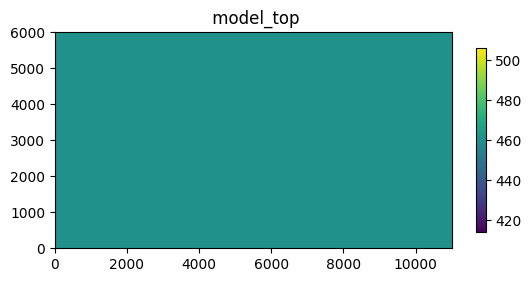

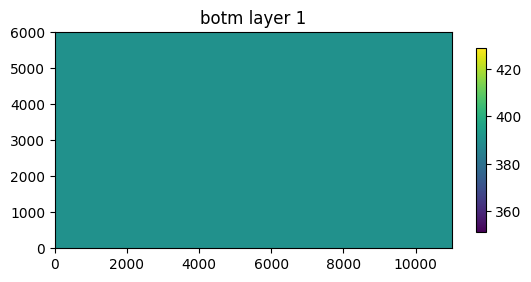

In [4]:
nlay = 1
nrow = 6
ncol = 11

delr = 6000/nrow
delc = 11000/ncol

dis = mf.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=460, botm=390, nper=1, steady=True)
dis.plot()

### Setup Boundary Conditions East/West

[<Axes: title={'center': ' CHD location stress period 1 layer 1'}>]

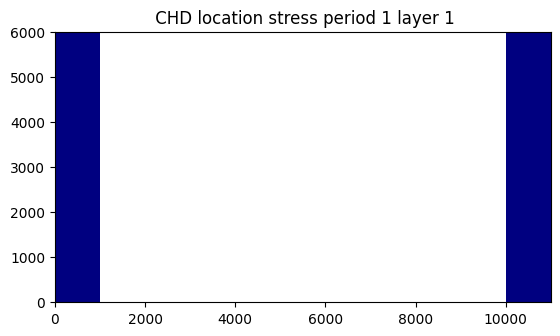

In [5]:
spd = {
    0: [
        [0, 0, 0, 450, 450],
        [0, 1, 0, 450, 450],
        [0, 2, 0, 450, 450],
        [0, 3, 0, 450, 450],
        [0, 4, 0, 450, 450],
        [0, 5, 0, 450, 450],
        [0, 0, 10, 445, 445],
        [0, 1, 10, 445, 445],
        [0, 2, 10, 445, 445],
        [0, 3, 10, 445, 445],
        [0, 4, 10, 445, 445],
        [0, 5, 10, 445, 445],
    ]
}

chd = mf.ModflowChd(model, stress_period_data=spd)
chd.plot()

### Setup Recharge


[<Axes: title={'center': 'RECH stress period 1'}>]

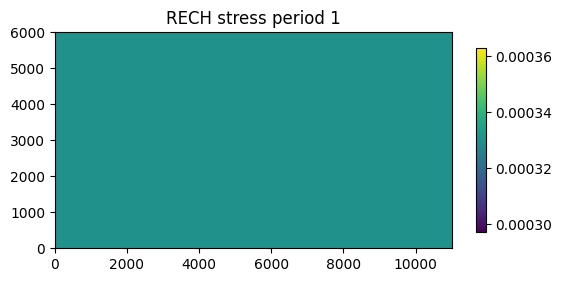

In [6]:
rech = {}
rech[0] = 0.00033
rch = mf.ModflowRch(model, rech=rech)
rch.plot()

### Setup River

[<Axes: title={'center': ' RIV location stress period 1 layer 1'}>]

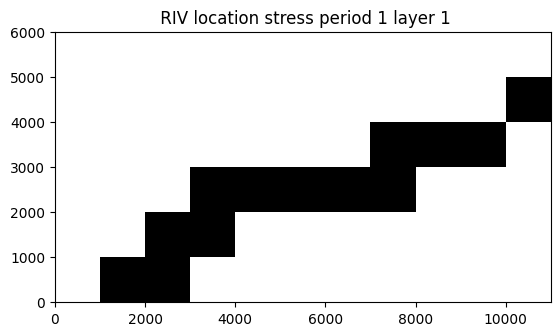

In [7]:
spd = {
    0: [
        [0, 5, 1, 450, 86.4, 448],
        [0, 5, 2, 450, 86.4, 448],
        [0, 4, 2, 450, 86.4, 448],
        [0, 4, 3, 450, 86.4, 448],
        [0, 3, 3, 450, 86.4, 448],
        [0, 3, 4, 450, 86.4, 448],
        [0, 3, 5, 450, 86.4, 448],
        [0, 3, 6, 450, 86.4, 448],
        [0, 3, 7, 450, 86.4, 448],
        [0, 2, 7, 450, 86.4, 448],
        [0, 2, 8, 450, 86.4, 448],
        [0, 2, 9, 450, 86.4, 448],
        [0, 1, 10, 450, 86.4, 448],        
    ]
}
riv = mf.ModflowRiv(model, stress_period_data=spd)
riv.plot()

### Setup Wells

[<Axes: title={'center': ' WEL location stress period 1 layer 1'}>]

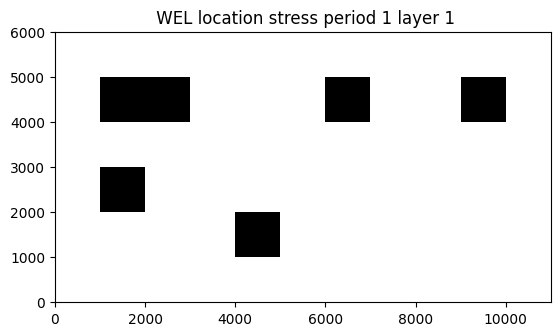

In [8]:
spd = {
    0: [
        [0, 1, 1, -5000],
        [0, 1, 2, -5000],
        [0, 1, 6, -10000],
        [0, 1, 9, -5000],
        [0, 3, 1, -5000],
        [0, 4, 4, -5000],
    ]
}
wel = mf.ModflowWel(model, stress_period_data=spd)
wel.plot()

### Setup lake

In [9]:
lakArr = np.zeros((nlay,nrow,ncol))
lakArr[0, 4, 9] = 1
lakArr[0, 0, 4] = 2

In [10]:
ibound = np.ones((nlay,nrow,ncol))
wetdry = -0.01 * np.ones((nlay,nrow,ncol))

ibound = np.where(lakArr > 0, 0, ibound) #IBOUND should be set to zero for every lake cell (LKARR >0)
wetdry = np.where(lakArr > 0, 0, wetdry) #WETDRY should be set to zero for every lake cell (LKARR >0)

In [11]:
bdlknc=np.zeros((nlay,nrow,ncol))
bdlknc = np.where(lakArr ==1, 10.0, bdlknc) #setting bed leakance value for lake 1
bdlknc = np.where(lakArr ==2, 20.0, bdlknc) #setting bed leakance value for lake 2

In [12]:
flux_data={0:[[0.003, 0.0073, 0.0, 0.0],
              [0.005, 0.0073, 0.0, 0.0]]}

In [13]:
lak = mf.ModflowLak(
    model,
    nlakes=2,
    theta=-1,
    nssitr=0,
    sscncr=0.001,
    surfdep=[0.5,0.7],
    stages=[449.0,448.5],
    stage_range=[[445.0,450.0], [444.5,452.0]],
    lakarr=lakArr,
    bdlknc=bdlknc,
    flux_data=flux_data,
    unit_number=16,
    lwrt=0,
)

### Setup Basic Package

[<Axes: title={'center': 'ibound layer 1'}>,
 <Axes: title={'center': 'strt layer 1'}>]

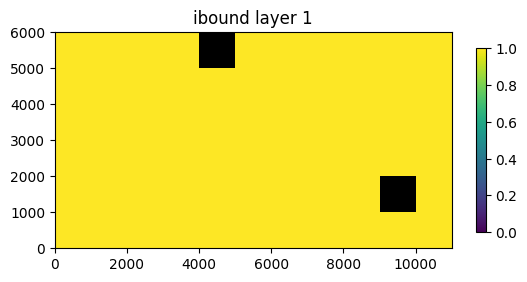

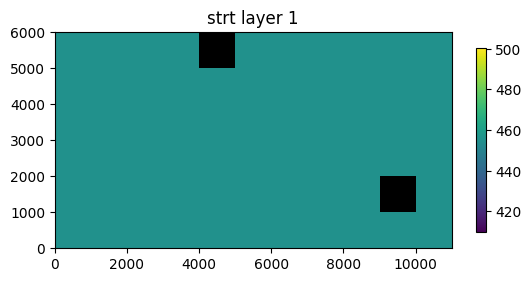

In [14]:
bas = mf.ModflowBas(model, ibound=ibound, strt=455.0)
bas.plot()

### Setup Flow-Package (incl. soil parameters)

[<Axes: title={'center': 'hk layer 1'}>,
 <Axes: title={'center': 'hani layer 1'}>,
 <Axes: title={'center': 'vka layer 1'}>,
 <Axes: title={'center': 'ss layer 1'}>,
 <Axes: title={'center': 'sy layer 1'}>,
 <Axes: title={'center': 'vkcb layer 1'}>,
 <Axes: title={'center': 'wetdry layer 1'}>]

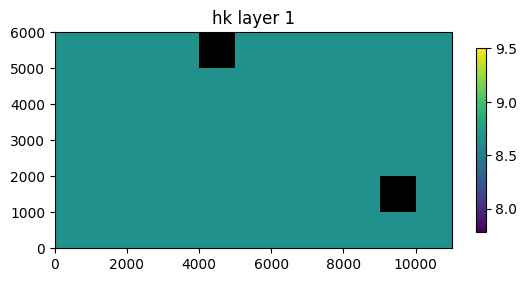

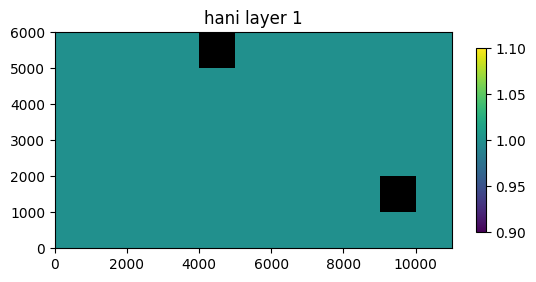

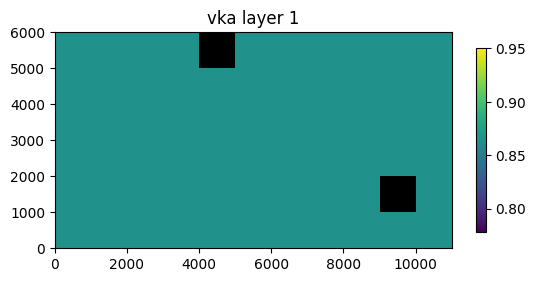

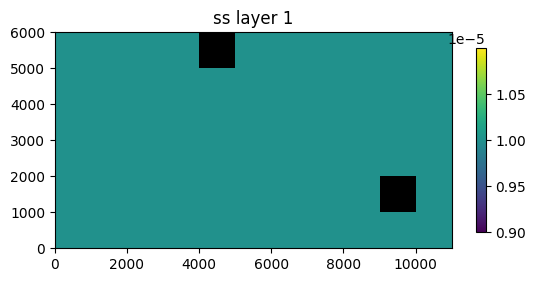

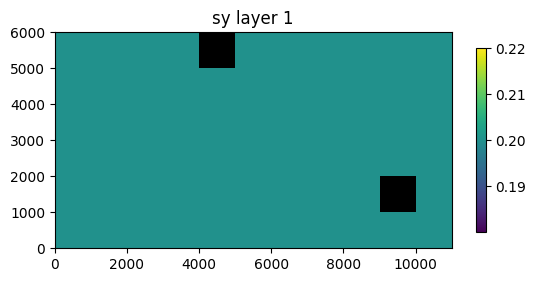

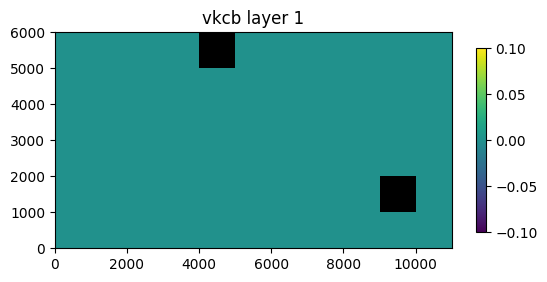

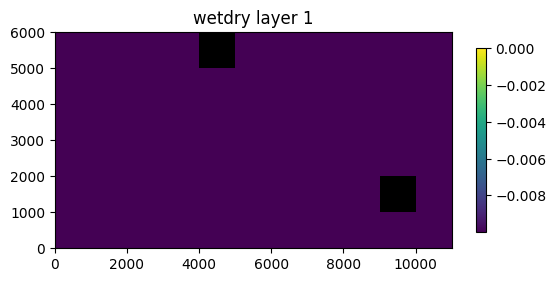

In [15]:
lpf = mf.ModflowLpf(model, hk=8.64, vka=0.864, ss=1e-5, sy=0.2, wetdry=wetdry)
lpf.plot()

### The Solver and Output Control

In [16]:
pcg = mf.ModflowPcg(model, rclose=1e-2, hclose=1e-2)
oc = mf.ModflowOc(model)

### Calculate the model

In [17]:
model.write_input()
model.run_model()

FloPy is using the following executable to run the model: ../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: RP1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/08/19 10:35:25

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/08/19 10:35:25
 Elapsed run time:  0.004 Seconds

  Normal termination of simulation


(True, [])

### Read calculated data

In [18]:
import flopy.utils as fu

hds = fu.HeadFile(os.path.join(workspace, 'RP1.hds'))
h = hds.get_data(kstpkper=(0,0))

### Plot

[]

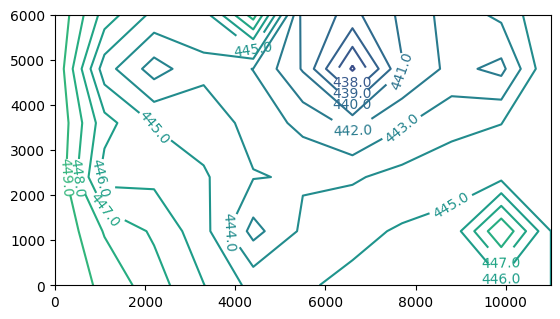

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(0, delr * ncol, ncol)
y = np.linspace(delc* nrow, 0, nrow)

c = plt.contour(x, y, h[0], np.arange(430.0, 460.0, 1.0))
plt.clabel(c, fmt='%2.1f')
plt.axis('scaled')
plt.plot()